In [15]:
"""
Second Jupyter notebook for playing with the database while the other one is busy scraping

"""

import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from godwin import Database, Scraper
import pandasql as ps
# import mpld3
# mpld3.enable_notebook()


db = Database('Godwin.db')
posts = db.get_data()
posts['num_prev_comments'] += 1  # Off-by-one correction
posts['num_prev_comments'].fillna(posts['num_comments'], inplace=True)
posts['failure'] = posts['comment_id'].notnull().astype('int')


qry = '''
        SELECT 
            subreddit, 
            count(comment_id) AS n_failing,
            count(post_id) AS n_total,
            round(100.0*count(comment_id)/count(post_id), 3)
                AS percent_failing,
            round(avg(num_comments), 3) 
                AS avg_comments,
            round(avg(num_prev_comments), 3) 
                AS avg_failure_comments
        FROM posts
        GROUP BY subreddit
        ORDER BY percent_failing DESC;
      '''
summary = ps.sqldf(qry, {'posts': posts})
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f'{summary.shape[0]} subs')
    display(summary)
    

186 subs


,subreddit,n_failing,n_total,percent_failing,avg_comments,avg_failure_comments
0,politics,76,101,75.248,3627.653,1081.040
1,AgainstHateSubreddits,120,171,70.175,518.503,72.123
2,insanepeoplefacebook,133,202,65.842,1926.673,395.371
3,ABoringDystopia,125,193,64.767,1149.912,306.093
4,worldnews,65,101,64.356,2399.693,736.416
5,facepalm,129,201,64.179,2123.189,540.010
6,europe,129,204,63.235,2365.485,421.466
7,Cringetopia,113,195,57.949,1934.744,803.472
8,news,58,101,57.426,3141.832,1527.109
9,PoliticalCompassMemes,57,104,54.808,789.135,360.827


/users/edsouza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


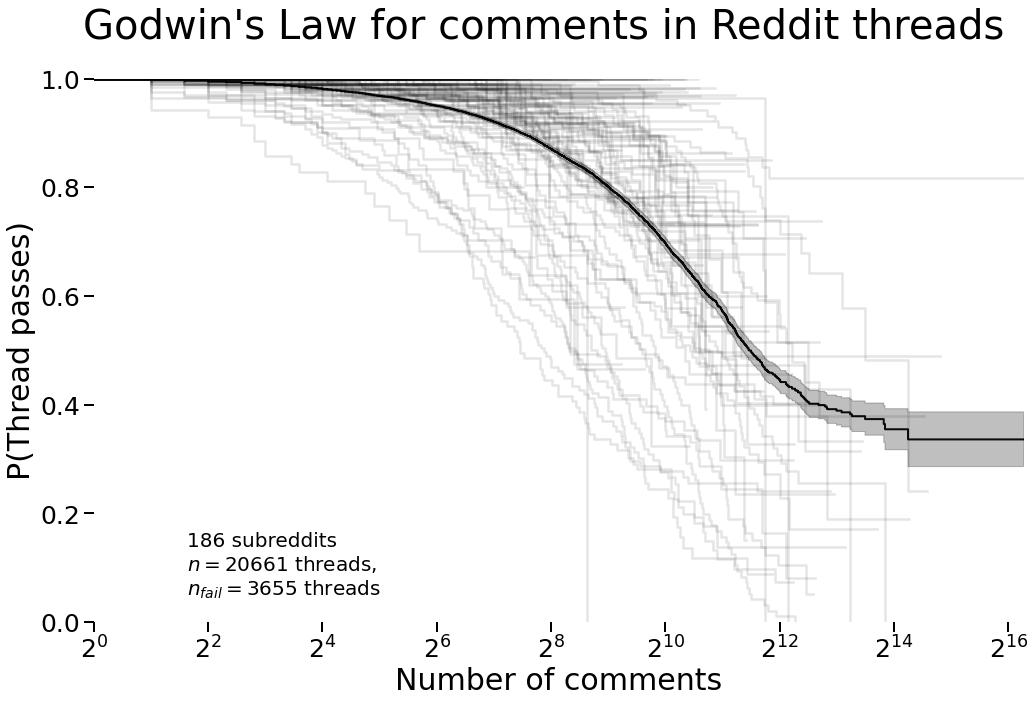

In [16]:
(fig, ax) = plt.subplots(1,1, figsize=(25 * 2/3, 15 * 2/3))

n = posts.shape[0]
n_fail = posts[posts.failure == 1].shape[0]

subs = posts.subreddit.str.lower().unique()  # Will plot noise from one-off posts on /r/all
subs = [i for i in subs 
        if i in Scraper.get_subs()]  # Will plot only the pre-defined list of major subs

for sub in subs:
    subset = posts[posts.subreddit == sub]
    if subset.shape[0] != 0:
        kmf = KaplanMeierFitter()
        kmf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
        kmf.plot(alpha=0.1, color='black', lw=2.5,
                 ci_show=False, ax=ax)
    
# Average model of all data
kmf = KaplanMeierFitter()
kmf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
kmf.plot(color='black', alpha=0.95, lw=2, ax=ax)
####################################################################################

fig.suptitle(f"Godwin's Law for comments in Reddit threads", fontsize=40)
ax.set_xlabel('Number of comments', fontsize=30)
ax.set_ylabel('P(Thread passes)', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.margins(x=0., y=0.)
fig.tight_layout()
ax.get_legend().remove()

samplesize = f"{len(subs)} subreddits\n$n={n}$ threads,\n${'n_{fail}'}={n_fail}$ threads"
plt.text(0.1, 0.05, samplesize, transform=ax.transAxes, fontsize=20)

plt.box(on=None)

ax.set_xscale('log', base=2)
# ax.set_xlim(0, 15000)

/users/edsouza/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


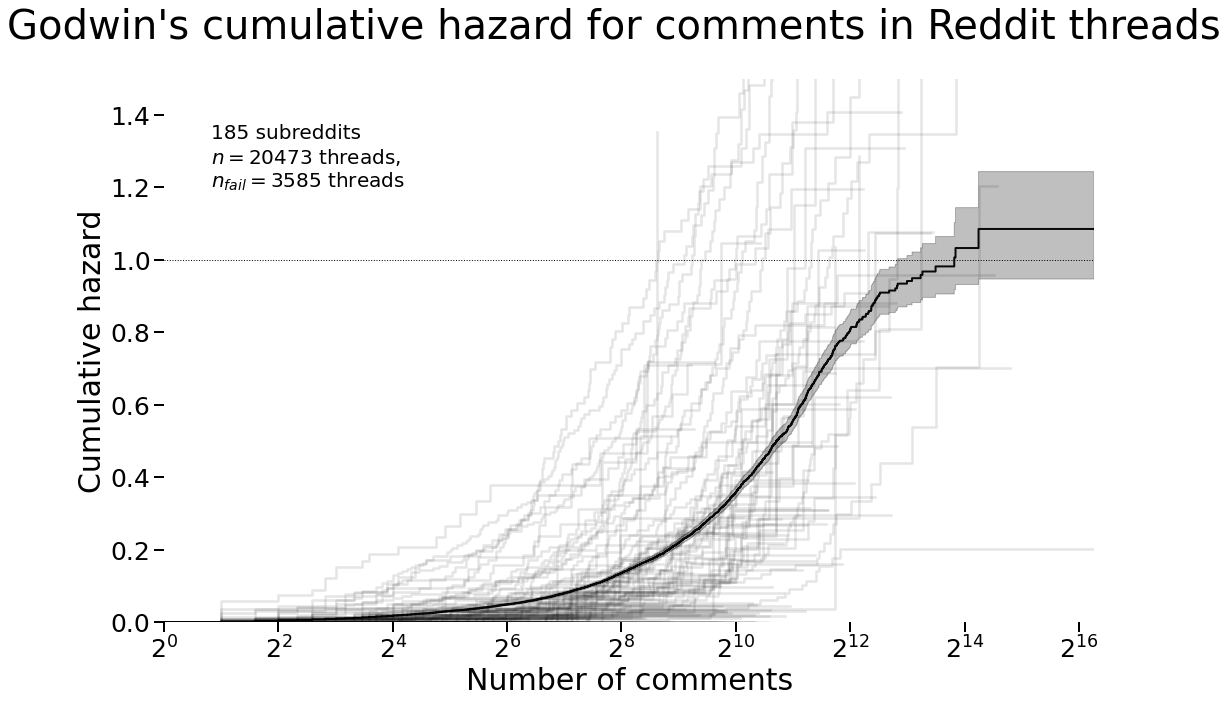

In [3]:
(fig, ax) = plt.subplots(1,1, figsize=(25 * 2/3, 15 * 2/3))

for sub in subs:
    subset = posts[posts.subreddit == sub]
    if subset.shape[0] != 0:
        naf = NelsonAalenFitter()
        naf.fit(subset['num_prev_comments'], event_observed=subset['failure'])
        naf.plot(alpha=0.1, color='black', lw=2.5,
                 ci_show=False, ax=ax)

naf = NelsonAalenFitter()
naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
naf.plot_cumulative_hazard(color='black', alpha=0.95, lw=2, ax=ax)

ax.axhline(y=1.0, xmin=0, xmax=posts.num_prev_comments.max(), ls=':', lw=1, color='black')
####################################################################################


fig.suptitle(f"Godwin's cumulative hazard for comments in Reddit threads", fontsize=40)
ax.set_xlabel('Number of comments', fontsize=30)
ax.set_ylabel('Cumulative hazard', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.tick_params(direction='out', length=10, width=2, colors='black')

ax.margins(x=0., y=0.)
fig.tight_layout()
ax.get_legend().remove()

samplesize = f"{len(subs)} subreddits\n$n={n}$ threads,\n${'n_{fail}'}={n_fail}$ threads"
plt.text(0.05, 0.8, samplesize, transform=ax.transAxes, fontsize=20)

ax.set_xscale('log', base=2)
ax.set_ylim(0, 1.5)

plt.box(on=None)

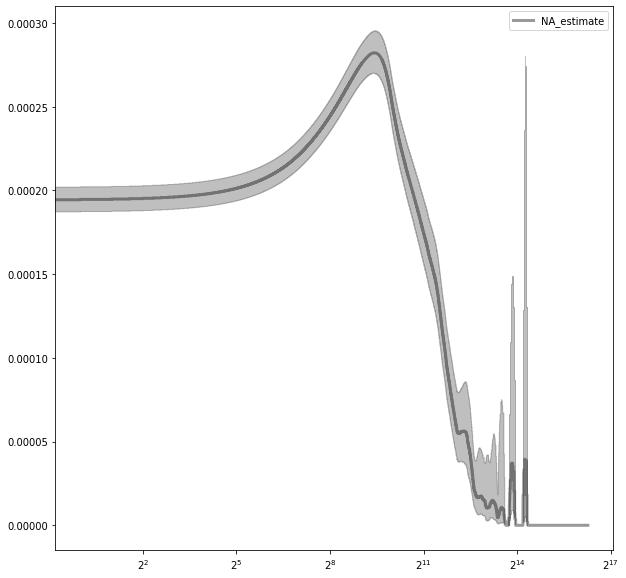

In [14]:
(fig, ax) = plt.subplots(1,1, figsize=(10,10))
naf = NelsonAalenFitter()
naf.fit(posts['num_prev_comments'], event_observed=posts['failure'])
#naf.plot_cumulative_hazard(color='black', alpha=0.4, ax=ax)
naf.plot_hazard(color='black', alpha=0.4, ax=ax, lw=3, bandwidth=1000)
ax.set_xscale('log', base=2)
# ax.set_xlim(0, 15000)

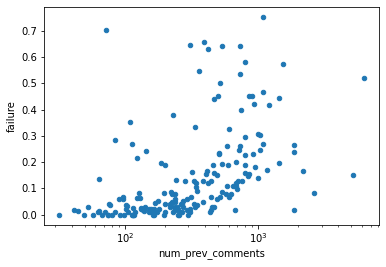

In [5]:
ax = posts.groupby(['subreddit']).mean().plot.scatter('num_prev_comments', 'failure')
ax.set_xscale('log', base=10)